# less stochastic optimizer


# 1. hypothesis


## 1.1. 가정

분산 노드 및 gpu의 퍼포먼스와 메모리가 늘어 나고 있는 상황에서 큰 batch (less stochastic)에서도 학습할 수 있는 방법을 고안안해서 보다 빠르게 학습하는 방법을 제안한다.

* 가정
  * batch사이즈가 클 수록 **local optimum과 saddle point는 줄어들 것**으로 예상되나 **paramete manifold의 shape이 전반적으로 smooth해 지고 un-sharp해질것**으로 예상
  * batch사이즈가 클 수록 parameter manifold가 batch각각의 manifold가 **global한 manifold와 비슷**해 질것으로 예상
* 해결 방법 및 잇점
  * second-order optimizer를 활용해 빠르게 converge하고, sample과 batch사이즈에 덜 민감하게 만든다
    * 기존의 learning-rate방식은 batch사이즈나 데이터에 민감하게 반응하고, 경험과 관찰에 의지하는 hyper-parameter로 찾기 어려웠음.
    * second-order optimizer를 활용하지 않는 이유는 local optimum에 쉽게 빠져들고, 각 sample에 따라 서로 다른 parameter로 converge하다보니 쉽게 발산한다.
  * 각 batch별 parameter를 찾고 async하게 merge하더라도 기존보다 안정적으로 converge할것으로 예상
  
  

## 1.2 데이터 확인 및 모델 설정

### 1.2.1 샘플 데이터 생성

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn import datasets
n_features = 10
X, label = datasets.samples_generator.make_classification(
    n_samples=1000, n_features=n_features, n_redundant=0, n_informative=2, n_clusters_per_class=2, flip_y=0.1, random_state=1)


plt.scatter(X[:, 0], X[:, 1], marker='o', c=label, s=25, edgecolor='k')

### 1.2.2 non-linear 모델 (3 layer)

In [3]:
import copy

class base(object):
    @staticmethod
    def tanh(x):
        return np.tanh(x)
    
    @staticmethod
    def relu(x):
        return np.maximum(x, 0, x)

    @staticmethod
    def sigmoid(x):
        return 1. / (1. + np.exp(-x))
    
    @staticmethod
    def x_entropy(y_hat, y):
        EPS = 1e-6
        return -np.mean( np.log(y_hat+EPS) * y + np.log(1.-y_hat+EPS) * (1.0 - y) )


class model(base):
    def __init__(self, num_params=2, num_layers=3, activation=base.relu):
        self.activation = activation
        self.W = [np.random.uniform(-1.0, 1.0, (num_params, num_params)) for i in range(num_layers)]
        self.W.append( np.random.uniform(-1.0, 1.0, (num_params, 1)) )
        self._W = copy.deepcopy(self.W)
        
    def reset(self):
        self.W = copy.deepcopy(self._W)
        
    def forward(self, X):
        x = X
        for w in self.W[:-1]:
            x = self.activation(np.dot(x, w))
        return base.sigmoid( np.dot(x, self.W[-1]) )
    
    def loss(self, X, y):
        return base.x_entropy(self.forward(X), y)
    
np.random.seed(0xC0FFEE)
m = model(n_features)
print(m.W[0])
print(m.loss(X, label))

## 1.2 parameter loss manifold shape

### 1.2.3 entire samples

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn.utils import shuffle

# Next line to silence pyflakes. This import is needed.
Axes3D

def manifold(model, samplesX, samplesLabel, model_index=0, grids=11):
    parameter_menifold={'space':[], 'loss':[]}
    space_range = 10.0
    for y in np.linspace(-space_range, space_range, num=grids):
        for x in np.linspace(-space_range, space_range, num=grids):
            model.reset()
            model.W[model_index][0, 0], m.W[model_index][1, 0] = x, y
            parameter_menifold['space'].append( (x, y) )
            parameter_menifold['loss'].append( m.loss(samplesX, samplesLabel) )
            
    x = np.array(parameter_menifold['space'])[:, 0].reshape(grids, grids)
    y = np.array(parameter_menifold['space'])[:, 1].reshape(grids, grids)
    z = np.array(parameter_menifold['loss']).reshape(grids, grids)
    parameter_menifold['surface'] = (x, y, z)
    parameter_menifold['z-range'] = (1.0, 4.0)
    return parameter_menifold

def draw(fig, parameter_menifold, sub_grids=[1,1], index=1):
    x = parameter_menifold['surface'][0]
    y = parameter_menifold['surface'][1]
    z = parameter_menifold['surface'][2]
    
    ax = fig.add_subplot(sub_grids[1], sub_grids[0], index, projection='3d')
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    ax.set_zlim(parameter_menifold['z-range'][0], parameter_menifold['z-range'][1])
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

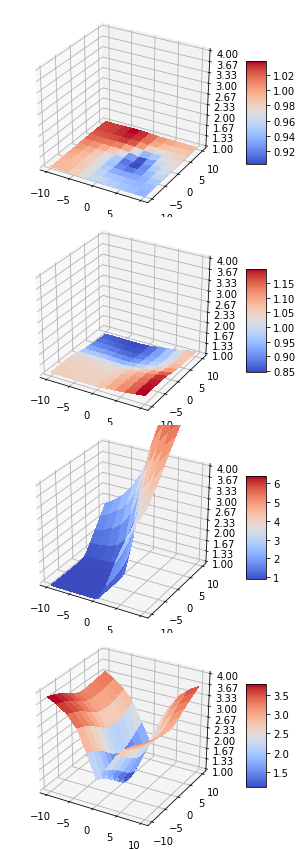

In [5]:
layers = len(m.W)
grids = [1, layers]
fig = plt.figure(figsize=(grids[0]*4, grids[1]*3))
fig.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
for layer in range(layers):
    parameter_menifold = manifold(m, X, label, model_index=layer)
    draw(fig, parameter_menifold, sub_grids=grids, index=layer+1)

### 1.2.3 stochastic samples (sample=1)

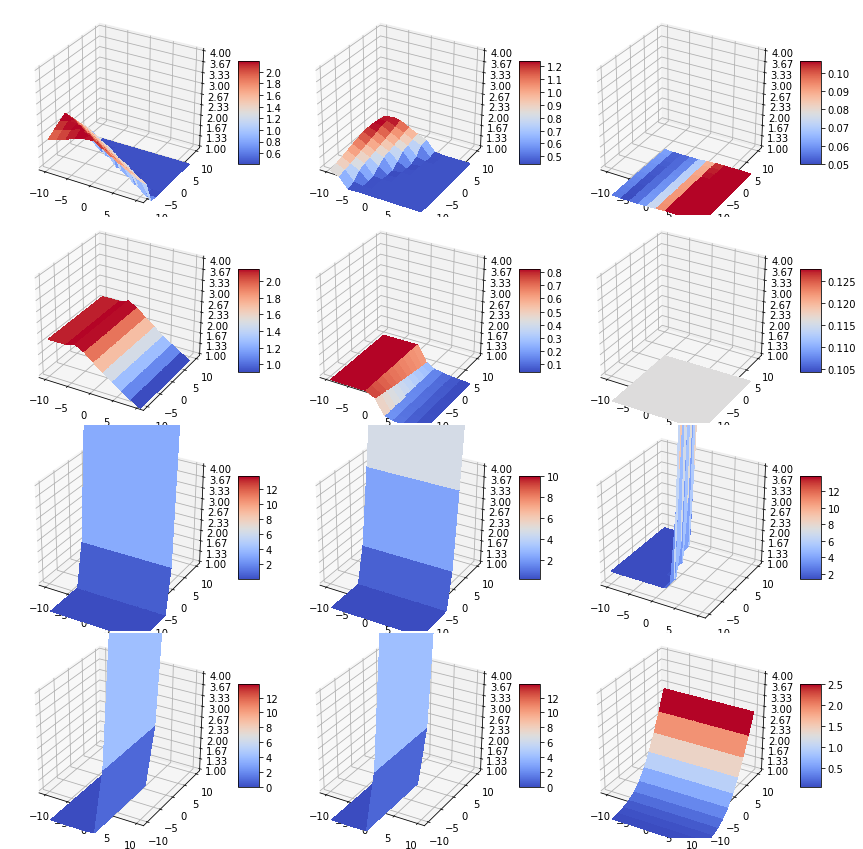

In [6]:
grids = [3, layers]
fig = plt.figure(figsize=(grids[0]*4, grids[1]*3))
fig.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

for y in range(grids[1]):
    for x in range(grids[0]):
        samplesX, samplesLabel = shuffle(X, label, n_samples=1)
        parameter_menifold = manifold(m, samplesX, samplesLabel, y)
        draw(fig, parameter_menifold, sub_grids=grids, index=y*grids[0]+x+1)

### 1.2.3 stochastic samples (sample=10)

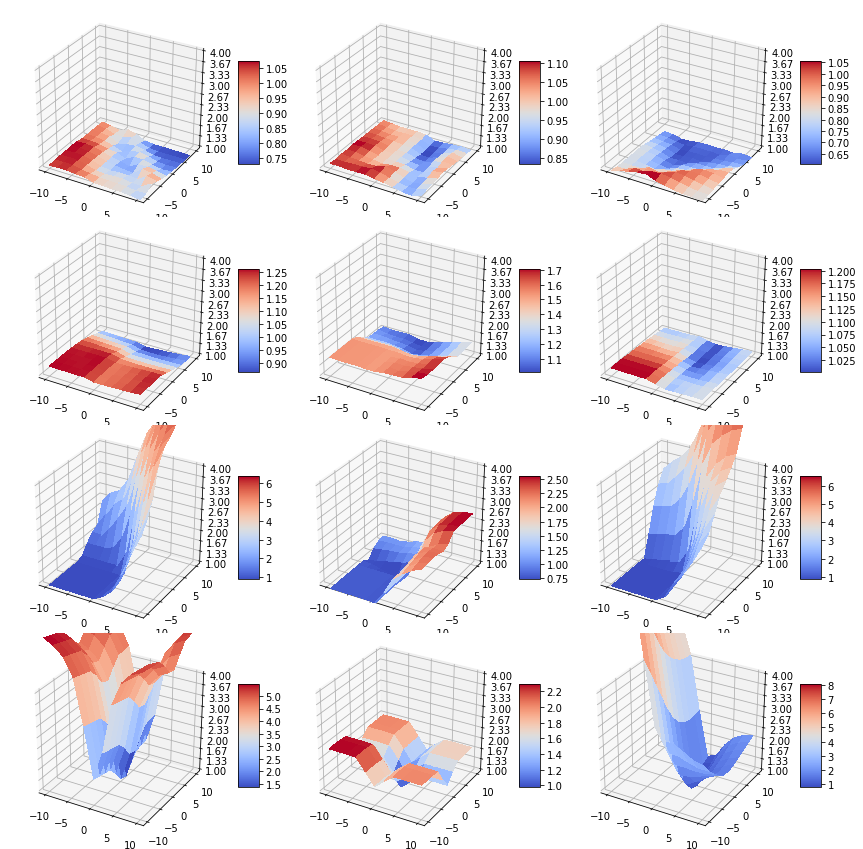

In [7]:
grids = [3, layers]
fig = plt.figure(figsize=(grids[0]*4, grids[1]*3))
fig.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

for y in range(grids[1]):
    for x in range(grids[0]):
        samplesX, samplesLabel = shuffle(X, label, n_samples=10)
        parameter_menifold = manifold(m, samplesX, samplesLabel, y)
        draw(fig, parameter_menifold, sub_grids=grids, index=y*grids[0]+x+1)

### 1.2.3 stochastic samples (sample=100)

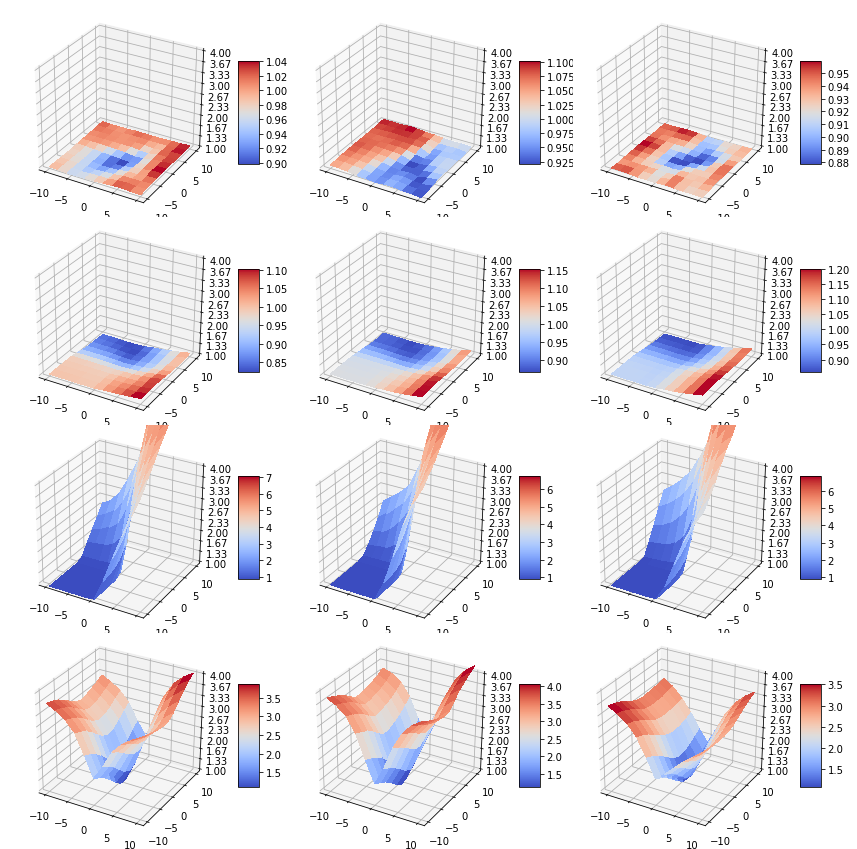

In [8]:
grids = [3, layers]
fig = plt.figure(figsize=(grids[0]*4, grids[1]*3))
fig.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

for y in range(grids[1]):
    for x in range(grids[0]):
        samplesX, samplesLabel = shuffle(X, label, n_samples=100)
        parameter_menifold = manifold(m, samplesX, samplesLabel, y)
        draw(fig, parameter_menifold, sub_grids=grids, index=y*grids[0]+x+1)

### 1.2.3 stochastic samples (sample=1000)

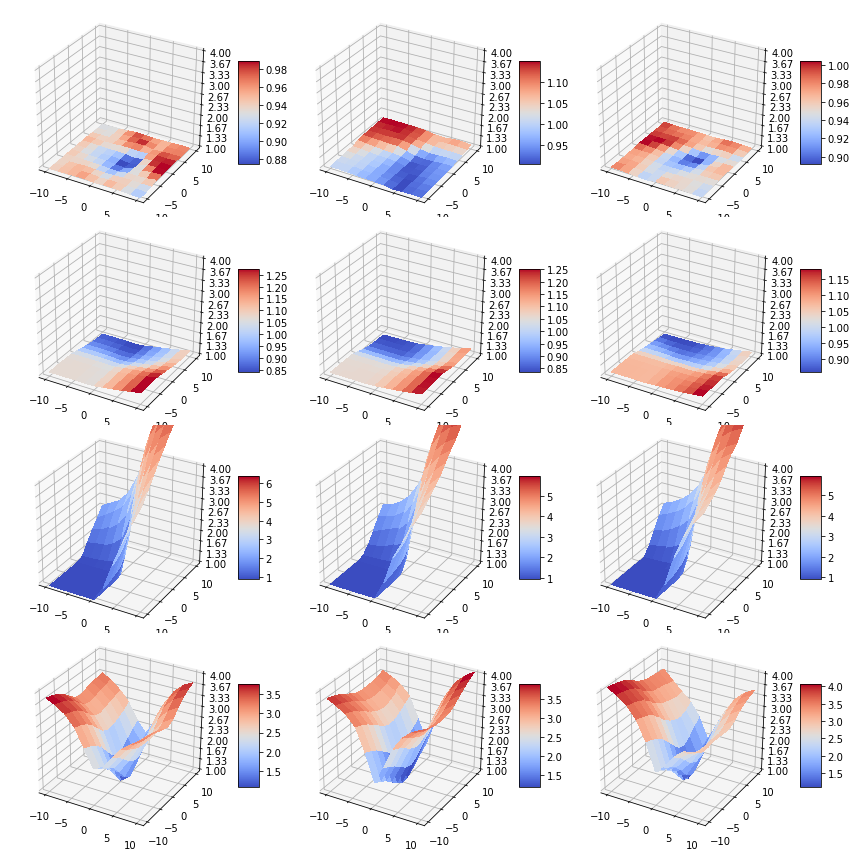

In [9]:
grids = [3, layers]
fig = plt.figure(figsize=(grids[0]*4, grids[1]*3))
fig.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

for y in range(grids[1]):
    for x in range(grids[0]):
        samplesX, samplesLabel = shuffle(X, label, n_samples=100)
        parameter_menifold = manifold(m, samplesX, samplesLabel, y)
        draw(fig, parameter_menifold, sub_grids=grids, index=y*grids[0]+x+1)

## 1.3 insight

* relu가 tanh보다 확실히 gradient가 크다.
* layer별로 input에 가까운 레이어에 gradient가 작다. (레이어별로 learning rate를 바꿔주면 도움이 될것 같다)
* batch사이즈가 클수록 graident가 작다. (un-sharp해졌다)
* batch사이즈가 클수록 global과 비슷해지고, 각각의 point의 gradient가 유사하게 나온다.


## 1.9 Apendix

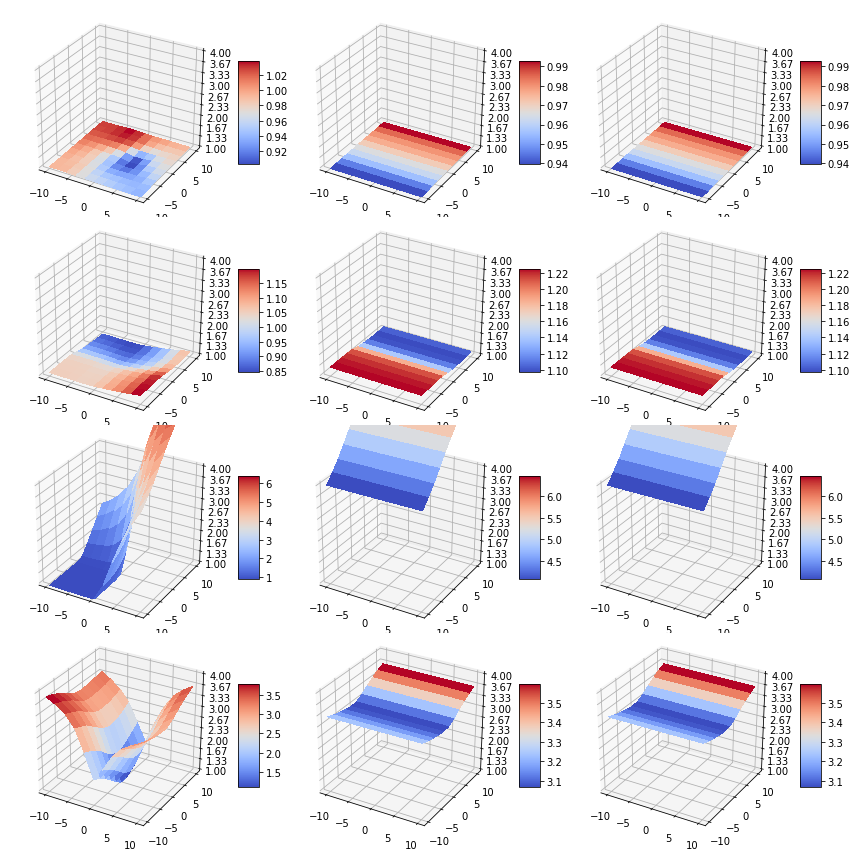

In [10]:
m_2 = model(n_features, activation=base.tanh)
m_3 = model(n_features, activation=base.sigmoid)
fig = plt.figure(figsize=(grids[0]*4, grids[1]*3))
fig.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
for layer in range(layers):
    parameter_menifold = manifold(m, X, label, model_index=layer)
    draw(fig, parameter_menifold, sub_grids=grids, index=layer*3+1)
    
    parameter_menifold = manifold(m_2, X, label, model_index=layer)
    draw(fig, parameter_menifold, sub_grids=grids, index=layer*3+2)
    
    parameter_menifold = manifold(m_3, X, label, model_index=layer)
    draw(fig, parameter_menifold, sub_grids=grids, index=layer*3+3)